In [1]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna.units import ureg
from svetlanna import wavefront as w

# Распространение пучка Гаусса

В этом примере будет использован функционал модуля `svetlanna.wavefront` для создания нескольких волновых фронтов.

Во-первых, необходимо создать расчетную сетку, используя класс `SimulationParameters`. Требуется задать размеры экрана $l_x\times l_y$, количество расчетных узлов $N_x\times N_y$ вдоль каждой из осей и длину волны(набор длин волн).

Во-вторых, необходимо использовать функционал `svetlanna.Wavefront.<wavefront_type>`  для создания требуемого волнового фронта. Доступны для создания следующие волновые фронты: пучок Гаусса, плоская волна, сферическая волна. Более того, существует возможность передать любой объект типа `torch.Tensor`, который описывает специфический волновой фронт, используя `svetlanna.Wavefront(<torch.Tensor>)`.

**Замечание:** существует возможность передать объект `torch.tensor([wavelength1, wavelength2, ..., wavelengthN])`, представляющий набор различных длин волн, в `SimulationParameters`, если необходимо распространить несколько волновых фронтов с различными длинами волн.

## Создание расчетной сетки с использованием класса `SimulationParameters`

In [3]:
Nx = 1500   # количество расчетных узлов в x направлении
Ny = 1500   # количество расчетных узлов в y направлении

lx = 16 * ureg.mm    # размер сетки в направлении x
ly = 16 * ureg.mm  # размер сетки в направлении y

wavelength = torch.tensor([330, 1064]) * ureg.nm  # набор длин волн

# cоздаем расчетную сетку
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})


In [4]:
# создаем двумерные тензоры, представляющие координаты точек на экране
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Создание заготовленных волновых фронтов
Создадим два пучка Гаусса с различными длинами волн, заданными выше. Оба пучка будут распространяться на расстояние $z$.

In [5]:
w0 = 2 * ureg.mm  # радиус перетяжки пучка Гаусса
z = 2 * ureg.cm  # расстояние распространения пучка

output_field = w.Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=w0,
    distance=z
)
# возвращаем распределение интенсивности волнового фронта
output_intensity = output_field.intensity

Визуализируем рассчитанные распределения интенсивности:

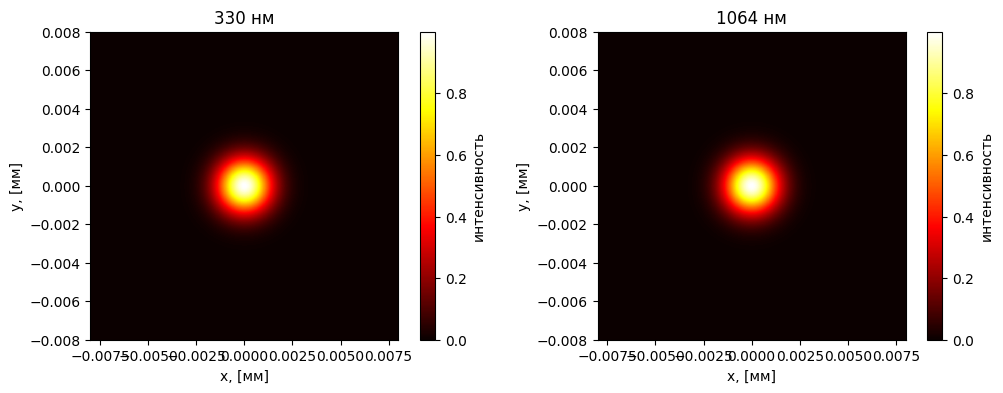

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
beam1 = ax[0].pcolormesh(x_grid.numpy(force=True), y_grid.numpy(force=True), output_intensity[0].numpy(force=True), cmap='hot')
beam2 = ax[1].pcolormesh(x_grid.numpy(force=True), y_grid.numpy(force=True), output_intensity[1].numpy(force=True), cmap='hot')

ax[0].set_title('330 нм')
ax[1].set_title('1064 нм')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('x, [мм]')
ax[0].set_ylabel('y, [мм]')
ax[1].set_xlabel('x, [мм]')
ax[1].set_ylabel('y, [мм]')
fig.colorbar(beam1, ax=ax[0], label='интенсивность')
fig.colorbar(beam2, ax=ax[1], label='интенсивность')

## Распространение волнового фронта произвольной формы

Возможно использование класса `svetlanna.elements.FreeSpace` для распространения волнового фронта произвольной формы с применением метода углового спектра или метода Френеля. Для этого необходимо определить:

1. Расстояние распространения
2. Метод распространения
3. Входящий волновой фронт, который необходимо передать в метод `.forward(incident_wavefront=<svetlanna.Wavefront>)` класса `FreeSpace`


Распространим созданные пучки на расстояние $z_0$:

In [7]:
z0 = 100 * ureg.cm  # расстояние распространения волнового фронта

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z0,
    method="AS"
)

free_space_output = free_space.forward(incident_wavefront=output_field)

free_space_output_intensity = free_space_output.intensity

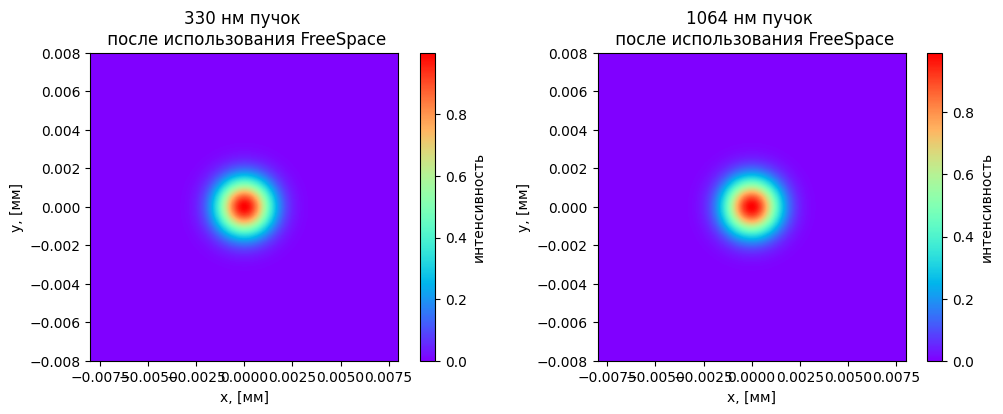

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
beam1 = ax[0].pcolormesh(x_grid.numpy(force=True), y_grid.numpy(force=True), free_space_output_intensity[0].numpy(force=True), cmap='rainbow')
beam2 = ax[1].pcolormesh(x_grid.numpy(force=True), y_grid.numpy(force=True), free_space_output_intensity[1].numpy(force=True), cmap='rainbow')

ax[0].set_title('330 нм пучок \n после использования FreeSpace')
ax[1].set_title('1064 нм пучок \n после использования FreeSpace')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('x, [мм]')
ax[0].set_ylabel('y, [мм]')
ax[1].set_xlabel('x, [мм]')
ax[1].set_ylabel('y, [мм]')
fig.colorbar(beam1, ax=ax[0], label='интенсивность')
fig.colorbar(beam2, ax=ax[1], label='интенсивность')